## SFINCS - grpc4bmi example

This notebook shows how the SFINCS BMI server built in this package can be used
with grpc4bmi. It assumes you have built the docker container with

```
cd src
docker build -t sfincs-bmiserver .
```

### Requirements

We use grpc4bmi to communicate with the BMI model inside a container.

In [1]:
# pip installa grpc4bmi

### Case specification

Lets use the example parameter set in https://github.com/Deltares/hydromt_sfincs/tree/main/examples/sfincs_compound

In [2]:
# !git clone https://github.com/Deltares/hydromt_sfincs/

Example above returns 0 for each time method, which is incorrect so we will use the alternate parameter set below

In [3]:
# !cp -r ~/dcache/parameter-sets/sfincs_humber ./
# !cp -r ~/ewatercycle/sfincs_humber ./

In [4]:
from pathlib import Path
parameter_set_dir = Path("sfincs_humber").absolute()
parameter_set_dir
import numpy as np

In [5]:
# see the sfincs internal data structure:
# note: the first value is the number of points (`np` in fortran code) and the length of our other arrays
indices = np.fromfile('sfincs_humber/sfincs.ind', dtype='int32')
print(len(indices))  
indices

313510


array([313509,    123,    124, ..., 803648, 803649, 803650], dtype=int32)

### Instantiate the model

This starts the model container and connects the client to it.
We can already get the component name

In [6]:
# Option 1: Build and run the container and connect to it

# from grpc4bmi.bmi_client_docker import BmiClientDocker
# model = BmiClientDocker(image='sfincs-bmiserver_tim', image_port=50051, work_dir=str(parameter_set_dir), delay=1)

# Option 2: Connect to the devcontainer directly, easy for development
# see https://github.com/eWaterCycle/sfincs-bmi-server#development-container
from grpc4bmi.bmi_grpc_client import BmiClient
import grpc
model = BmiClient(grpc.insecure_channel("localhost:50051"))

In [7]:
model.get_component_name()

'Sfincs hydrodynamic model (C)'

### Interact with the model

We can initialize the model and see that it had effect: time variables seem to be set from the input file

In [8]:
model.initialize(str(parameter_set_dir / 'sfincs.inp'))

In [9]:
model.update()

In [10]:
{
    'get_current_time': model.get_current_time(), 
    'get_start_time':model.get_start_time(),
    'get_end_time': model.get_end_time(), 
    'get_time_units': model.get_time_units(), 
    'get_time_step': model.get_time_step(),
}

{'get_current_time': 950400.0,
 'get_start_time': 950400.0,
 'get_end_time': 950400.0,
 'get_time_units': 's',
 'get_time_step': 9.999999974752427e-07}

In [11]:
# Var methods
{
    'get_input_item_count': model.get_input_item_count(),
    'get_output_item_count': model.get_output_item_count(),
    'get_input_var_names': model.get_input_var_names(),
    'get_output_var_names': model.get_output_var_names(),
    'get_var_grid': model.get_var_grid('zs'),
    'get_var_itemsize': model.get_var_itemsize('zs'),
    'get_var_nbytes': model.get_var_nbytes('zs'),
    'get_var_type': model.get_var_type('zs'),
    'get_var_units': model.get_var_units('zs'),
}

{'get_input_item_count': 6,
 'get_output_item_count': 10,
 'get_input_var_names': ('zs', 'zb', 'qsrc_1', 'qsrc_2', 'tsrc', 'zst_bnd'),
 'get_output_var_names': ('z_xz',
  'z_yz',
  'zs',
  'zb',
  'qsrc_1',
  'qsrc_2',
  'xsrc',
  'ysrc',
  'tsrc',
  'zst_bnd'),
 'get_var_grid': 0,
 'get_var_itemsize': 4,
 'get_var_nbytes': 1254036,
 'get_var_type': 'float32',
 'get_var_units': 'm above reference level'}

In [12]:
{
    'get_var_grid': model.get_var_grid('qsrc_1'),
    'get_var_itemsize': model.get_var_itemsize('qsrc_1'),
    'get_var_nbytes': model.get_var_nbytes('qsrc_1'),
    'get_var_type': model.get_var_type('qsrc_1'),
    'get_var_units': model.get_var_units('qsrc_1'),
}

{'get_var_grid': 1,
 'get_var_itemsize': 4,
 'get_var_nbytes': 100,
 'get_var_type': 'float32',
 'get_var_units': None}

In [13]:
# model.get_var_location('zs')
# Throws grpc4bmi erorr, maybe because enum in C and Python not matching

In [14]:
# model.get_grid_shape(1, np.zeros((1), dtype=int))
# not defined in bmi for unstructured grid

In [15]:
# Grid methods
grid_id = 0
{
    'get_grid_rank': model.get_grid_rank(grid_id),
    'get_grid_size': model.get_grid_size(grid_id),
    'get_grid_type': model.get_grid_type(grid_id),
    # 'get_grid_shape': model.get_grid_shape(grid_id, np.empty(model.get_grid_rank(grid_id), dtype=int))
}


{'get_grid_rank': 2, 'get_grid_size': 313509, 'get_grid_type': 'unstructured'}

In [16]:
size = model.get_grid_size(0)
size

313509

In [17]:
model.get_value('qsrc_1', np.zeros(25, dtype=np.float32))
# model.set_value('qsrc_1', 1.5*np.ones(25, dtype=np.float32))
model.get_value('qsrc_1', np.zeros(25, dtype=np.float32))
model.get_value('qsrc_1', np.zeros(25, dtype=np.float32))

array([1.2735e+02, 1.3934e+02, 2.3900e+01, 1.5710e+01, 7.8300e+00,
       4.1100e+00, 3.6500e+00, 9.3000e-01, 1.3300e+00, 3.9000e-01,
       4.6000e-01, 3.2000e-01, 2.5000e-01, 1.4000e-01, 1.6000e-01,
       1.3000e-01, 2.0000e-01, 2.4000e-01, 2.5000e-01, 2.3000e-01,
       1.3000e-01, 1.6000e-01, 1.2000e-01, 1.9000e-01, 8.0000e-02],
      dtype=float32)

In [18]:
model.get_value('zs', np.zeros(size, dtype=np.float32))

array([9.641531 , 9.0527935, 8.568492 , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [19]:
model.get_value('qsrc_2', np.zeros(25, dtype=np.float32))

array([1.2740e+02, 1.3748e+02, 2.3550e+01, 1.5490e+01, 7.7400e+00,
       4.1200e+00, 3.6100e+00, 9.2000e-01, 1.3100e+00, 3.9000e-01,
       4.6000e-01, 3.2000e-01, 2.5000e-01, 1.4000e-01, 1.6000e-01,
       1.3000e-01, 2.0000e-01, 2.4000e-01, 2.4000e-01, 2.3000e-01,
       1.2000e-01, 1.6000e-01, 1.1000e-01, 1.8000e-01, 8.0000e-02],
      dtype=float32)

In [20]:
model.get_value('tsrc', np.zeros(model.get_grid_size(model.get_var_grid('tsrc')), dtype=np.float32))
model.set_value('tsrc', np.array([2, 10], dtype=np.float32))
model.get_value('tsrc', np.zeros(model.get_grid_size(model.get_var_grid('tsrc')), dtype=np.float32))

array([ 2., 10.], dtype=float32)

In [21]:
# model.get_value('xsrc', np.zeros(25, dtype=np.float32))
# model.get_grid_x(0, np.empty(size, dtype=np.float32))
# Gives segmentation fault which kills container

In [22]:
# Check consistency of return values
attempt_1 = model.get_value('z_xz', np.zeros(size, dtype=np.float32))
attempt_2 = model.get_value('z_xz', np.zeros(size, dtype=np.float32))
np.testing.assert_allclose(attempt_1, attempt_2)

In [23]:
print(
    model.get_var_type('xsrc'),
    item_size := model.get_var_itemsize('xsrc'),
    total_size := model.get_var_nbytes('xsrc'),
    total_size // item_size,
)

float32 4 100 25


(array([1.89096e+05, 8.22210e+04, 2.49120e+04, 1.15470e+04, 4.16400e+03,
        1.15700e+03, 2.55000e+02, 9.30000e+01, 5.60000e+01, 8.00000e+00]),
 array([ 0.        ,  4.55390024,  9.10780048, 13.66170025, 18.21560097,
        22.76950073, 27.3234005 , 31.87730026, 36.43120193, 40.98509979,
        45.53900146]),
 <BarContainer object of 10 artists>)

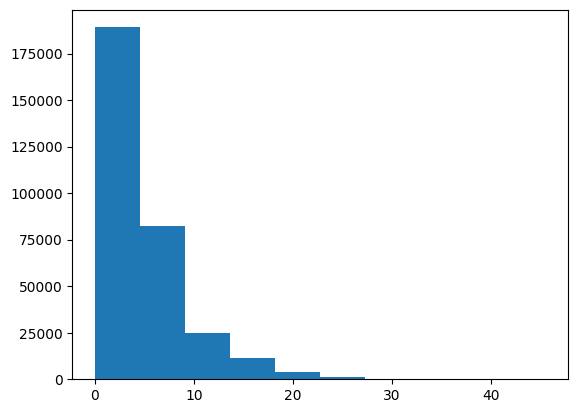

In [24]:
import matplotlib.pyplot as plt
plt.hist(model.get_value('zs', np.zeros(size, dtype=np.float32)))

In [25]:
# model.get_value_at_indices('z_xz', np.array([0, 1, 2], dtype='int32'), np.zeros(3, dtype=np.float32))
# segfault

In [26]:
model.get_current_time()
model.update_until(10.)
model.get_current_time()


950410.499130249

In [27]:
for i in range(10):
    print(model.get_current_time())
    model.update()
    

950410.499130249
950415.7486953735
950420.998260498
950426.2478256226
950431.4973907471
950436.7469558716
950441.9965209961
950447.2460861206
950452.4956512451
950457.7452163696


(array([1.50933e+05, 1.05755e+05, 3.64440e+04, 1.33810e+04, 5.07600e+03,
        1.46100e+03, 2.92000e+02, 9.90000e+01, 5.90000e+01, 9.00000e+00]),
 array([-1.27353752,  3.40771627,  8.08897018, 12.77022457, 17.45147896,
        22.13273239, 26.81398582, 31.49523926, 36.1764946 , 40.85774612,
        45.53900146]),
 <BarContainer object of 10 artists>)

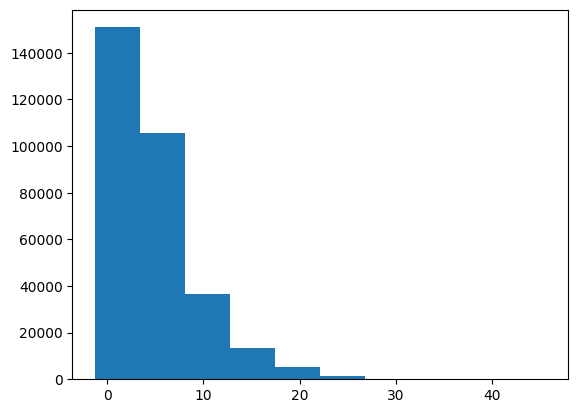

In [28]:
model.get_value('zs', np.zeros(size))
plt.hist(model.get_value('zs', np.zeros(size, dtype=np.float32)))